## Albumentations library for generating various augmentations

In [51]:
!pip install torch torchvision albumentations

## Imports

In [95]:
import os
import cv2
import glob
import time
import torch
import psutil
import random
import warnings
import torchvision
import numpy as np
import seaborn as sns
import concurrent.futures
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib.patches as patches
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # This forces CUDA to run operations synchronously

## Functions to read images and masks

In [96]:
def read_image(image_path):
    bgr_image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

def load_images_masks(data_dir):
    images = []
    masks = []
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        for image_filename in os.listdir(folder_path):
            if image_filename.endswith(".jpg"):
                mask_filename = image_filename[:-4] + "_m.png"
                image_path = os.path.join(folder_path, image_filename)
                mask_path = os.path.join(folder_path, mask_filename)
                images.append(read_image(image_path))
                masks.append(read_image(mask_path))
    return images, masks

## Reading images

In [97]:
data_dir = "/kaggle/input/segmentation-masks/data"
images, masks = load_images_masks(data_dir)

print("Number of images loaded:", len(images))
print("Number of masks loaded:", len(masks))

Number of images loaded: 3961
Number of masks loaded: 3961


## Visualise Images and Masks

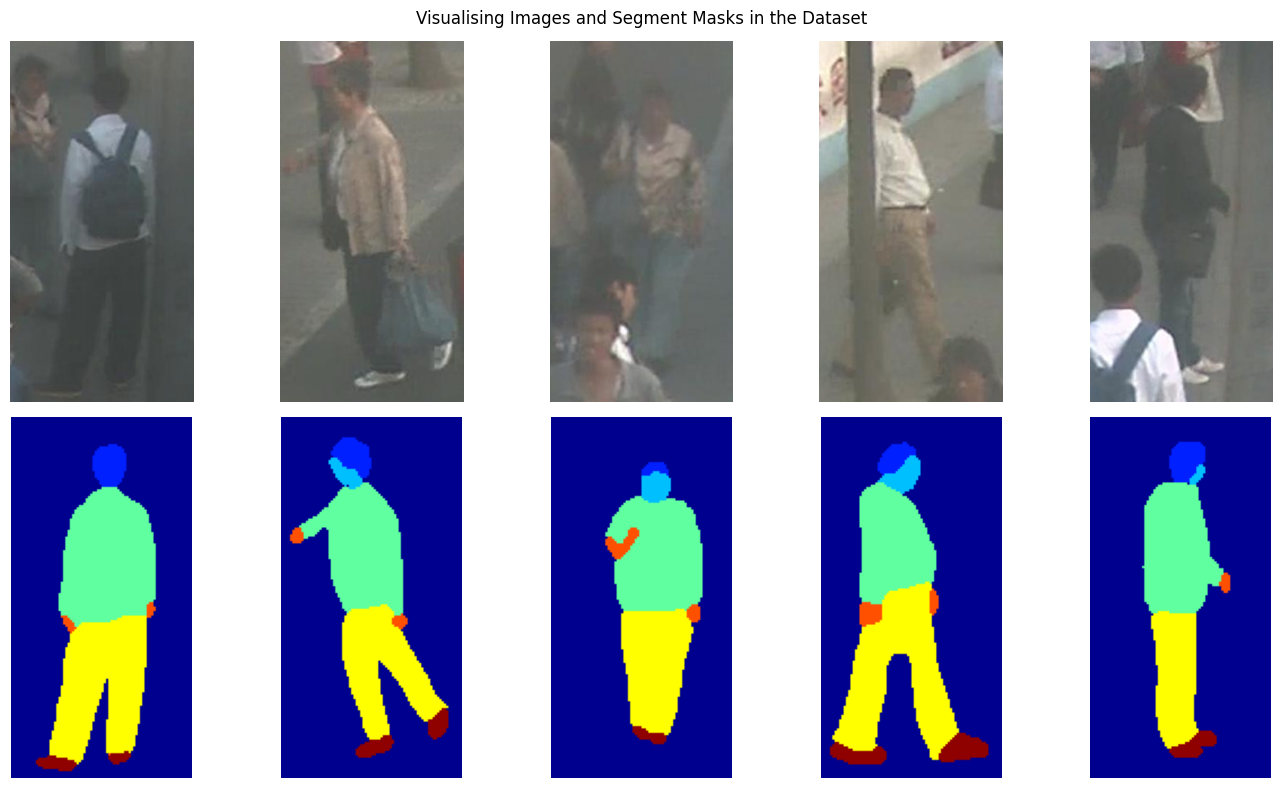

In [108]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i in range(5):
    axes[0][i].imshow(images[i])
    axes[1][i].imshow(masks[i])
    axes[0][i].axis("off")
    axes[1][i].axis("off")
plt.tight_layout()
plt.suptitle("Visualising Images and Segment Masks in the Dataset")
plt.tight_layout()
plt.show()

## Functions to calculate and draw Bounding Boxes

In [99]:
# This I have identified after accessing images closely and their grayscale segment maps
# These values are pixel values on [0, 255] grayscale

# Earlier:
# pixel_labels = {
#     16: "background",
#     48: "hair",
#     141: "face",
#     197: "torso",
#     123: "hand",
#     226: "lower",
#     52: "leg",
#     43: "footwear"
# }

# pixel_val_to_label_map = {
#     16: 0,
#     43: 1,
#     48: 2,
#     52: 3,
#     123: 4,
#     141: 5,
#     197: 6,
#     226: 7
# }

# After visualising the distribution of various labels we found that the leg label has very few samples -> so updated the code and labels
# to include leg into lower itself
pixel_labels = {
    16: "background",
    48: "hair",
    141: "face",
    197: "torso",
    123: "hand",
    226: "lower",
    # 52: "leg",
    43: "footwear"
}

pixel_val_to_label_map = {
    16: 0,
    43: 1,
    48: 2,
    # 52: 3,
    123: 3,
    141: 4,
    197: 5,
    226: 6
}

def get_bounding_boxes_and_labels(mask, min_area=0):
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

    # Replacing all the leg (52) with lower (226)
    mask = np.where(mask == 52, 226, mask)

    unique_values = np.unique(mask)
    unique_values = unique_values[unique_values != 16]  # Exclude background (assuming 16 is background - by observing after printing a grayscale image of some masks)

    bounding_boxes = []
    labels = []

    global cls_freq

    for val in unique_values:
        # Create a binary mask for the current value
        binary_mask = (mask == val).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            if cv2.contourArea(cnt) >= min_area:  # Discard small contours
                if cls_freq.get(val, None) is not None:
                    cls_freq[val] += 1
                else:
                    cls_freq[val] = 1
                x, y, w, h = cv2.boundingRect(cnt)
                bounding_boxes.append((x, y, w, h))
                labels.append(pixel_val_to_label_map[val])

    return bounding_boxes, labels

def scale_bounding_boxes(original_images, mask_images, bounding_boxes):
    scaled_bboxes = []

    for i in range(len(original_images)):
        orig_h, orig_w = original_images[i].shape[:2]  # Original image size
        mask_h, mask_w = mask_images[i].shape[:2]      # Mask image size

        scale_x = orig_w / mask_w
        scale_y = orig_h / mask_h

        scaled_bboxes.append([
            (int(x * scale_x), int(y * scale_y), int(w * scale_x), int(h * scale_y))
            for (x, y, w, h) in bounding_boxes[i]
        ])

    return scaled_bboxes

def draw_bounding_boxes(image, bounding_boxes):
    img = image.copy()
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    return img

## Generating bounding boxes

In [100]:
cls_freq = {}
bounding_boxes = []
labels = []
for mask in masks:
    (bbox, label) = get_bounding_boxes_and_labels(mask, min_area=1)
    bounding_boxes.append(bbox)
    labels.append(label)

scaled_bounding_boxes = scale_bounding_boxes(images, masks, bounding_boxes)

print(f"Number of images for which BB are generated = {len(bounding_boxes)}")

Number of images for which BB are generated = 3961


## Visualising Bounding Boxes

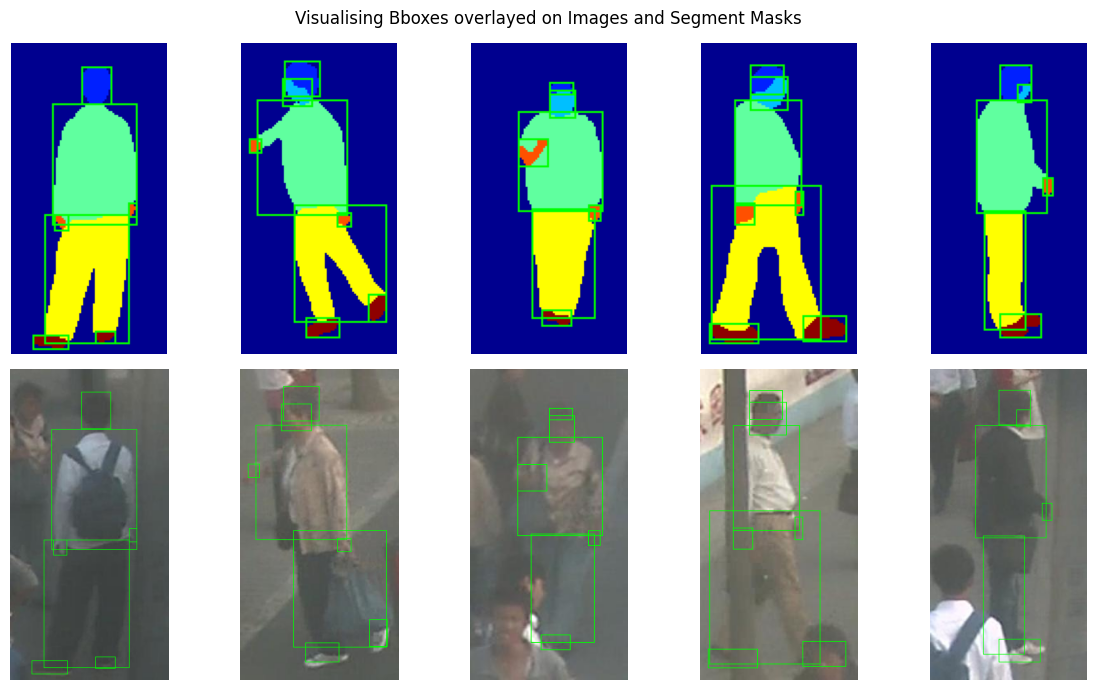

In [109]:
fig, axes = plt.subplots(2, 5, figsize=(12, 7))

for i in range(5):
    axes[0][i].imshow(draw_bounding_boxes(masks[i], bounding_boxes[i]))
    axes[0][i].axis("off")
    axes[1][i].imshow(draw_bounding_boxes(images[i], scaled_bounding_boxes[i]))
    axes[1][i].axis("off")
plt.suptitle("Visualising Bboxes overlayed on Images and Segment Masks")
plt.tight_layout()
plt.show()

## Dividing data in train and val sets

In [102]:
val_size = 0.2
random_state = 32

train_images, val_images, train_masks, val_masks, train_bboxes, val_bboxes, train_scaled_bboxes, val_scaled_bboxes, train_labels, val_labels = train_test_split(
        images, masks, bounding_boxes, scaled_bounding_boxes, labels, test_size=val_size, random_state=random_state
)

print(f"Number of datapoints in images train split = {len(train_images)}")
print(f"Number of datapoints in masks train split = {len(train_masks)}")
print(f"Number of datapoints in Bboxes train split = {len(train_bboxes)}")
print(f"Number of datapoints in Scaled Bboxes train split = {len(train_scaled_bboxes)}")
print(f"Number of datapoints in labels train split = {len(train_labels)}")
print()
print(f"Number of datapoints in images val split = {len(val_images)}")
print(f"Number of datapoints in masks val split = {len(val_masks)}")
print(f"Number of datapoints in Bboxes val split = {len(val_bboxes)}")
print(f"Number of datapoints in Scaled Bboxes val split = {len(val_scaled_bboxes)}")
print(f"Number of datapoints in labels val split = {len(val_labels)}")

Number of datapoints in images train split = 3168
Number of datapoints in masks train split = 3168
Number of datapoints in Bboxes train split = 3168
Number of datapoints in Scaled Bboxes train split = 3168
Number of datapoints in labels train split = 3168

Number of datapoints in images val split = 793
Number of datapoints in masks val split = 793
Number of datapoints in Bboxes val split = 793
Number of datapoints in Scaled Bboxes val split = 793
Number of datapoints in labels val split = 793


## **Approach Breakdown**

### **Bounding Box Extraction**
- Converts masks to grayscale and detects unique objects.
- Uses `cv2.findContours()` to find object boundaries.
- Filters out small contours (`min_area`) to remove noise.

**Justification:**  
- Avoids background interference.  
- Ensures only significant objects are considered.

---

### **Scaling Bounding Boxes**
- Since masks are smaller than original images, bounding boxes are scaled using width and height ratios.

**Justification:**  
- Ensures proper alignment of bounding boxes with objects in the original image.

---

### **Drawing Bounding Boxes**
- Uses `cv2.rectangle()` to overlay bounding boxes on images for visualization.

**Justification:**  
- Helps verify correct bounding box placement.

---

### **Dataset Splitting**
- Splits dataset into train (80%) and validation (20%) using `train_test_split()` while maintaining correspondence across images, masks, and bounding boxes.

**Justification:**  
- Provides a balanced evaluation dataset.  
- Ensures reproducibility with a fixed `random_state`.


## Analysing Data and Bboxes

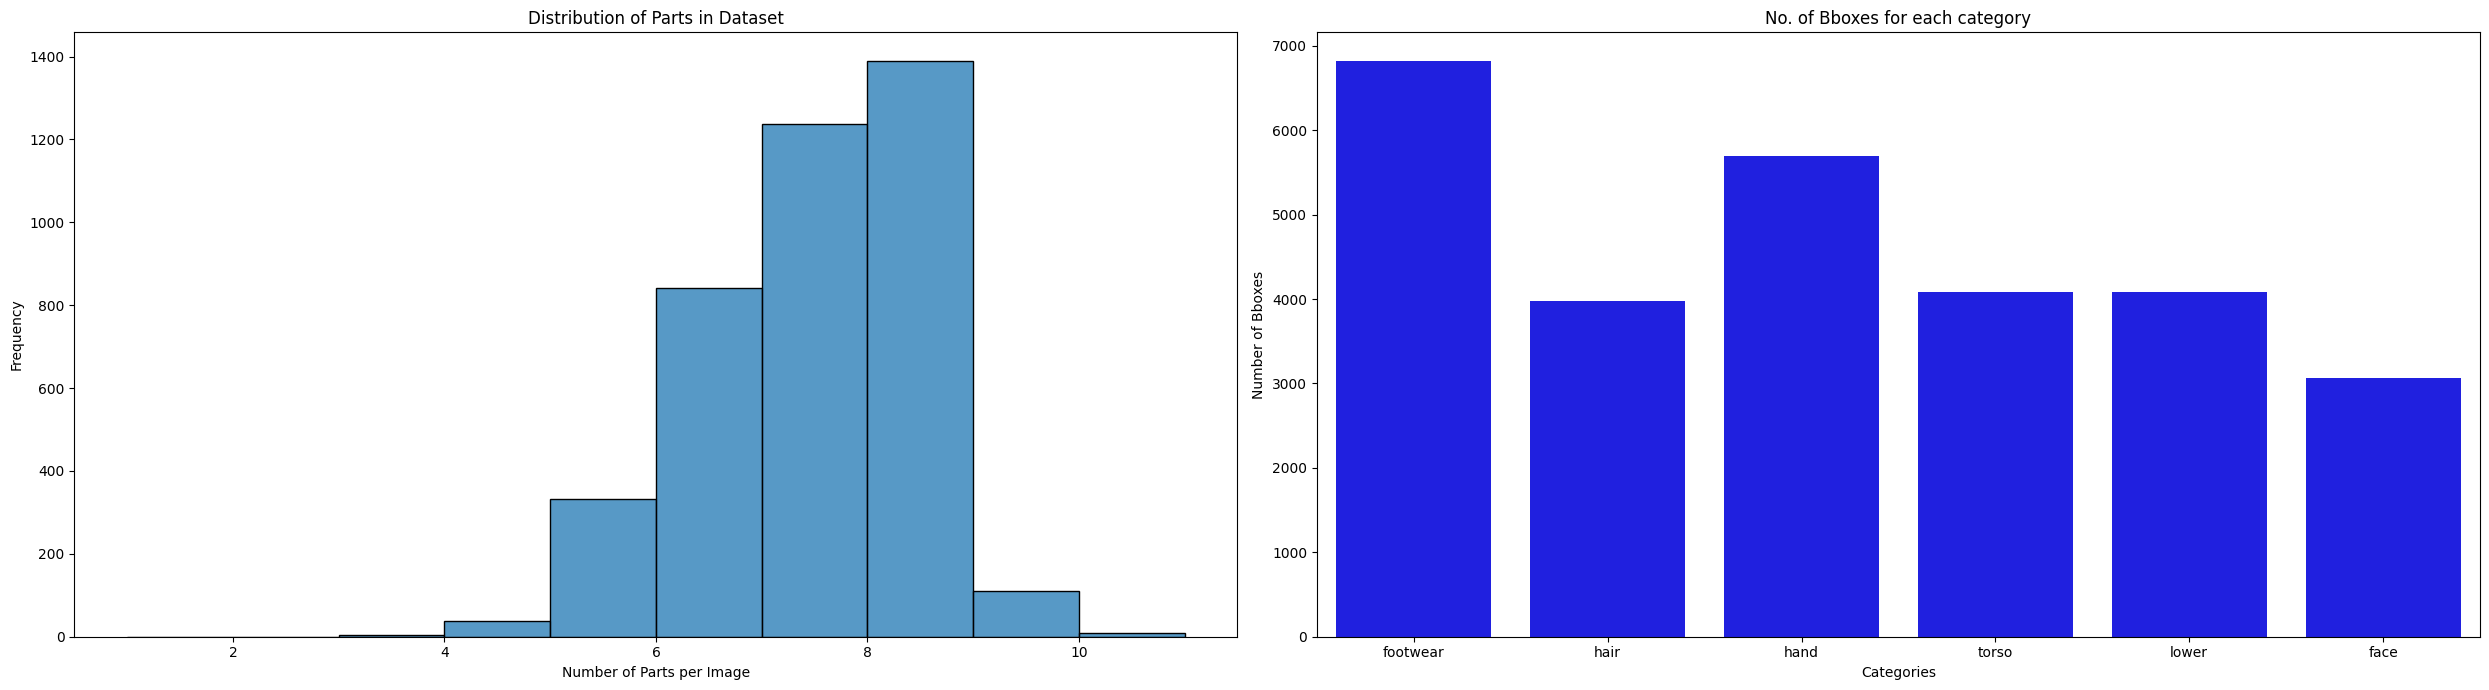

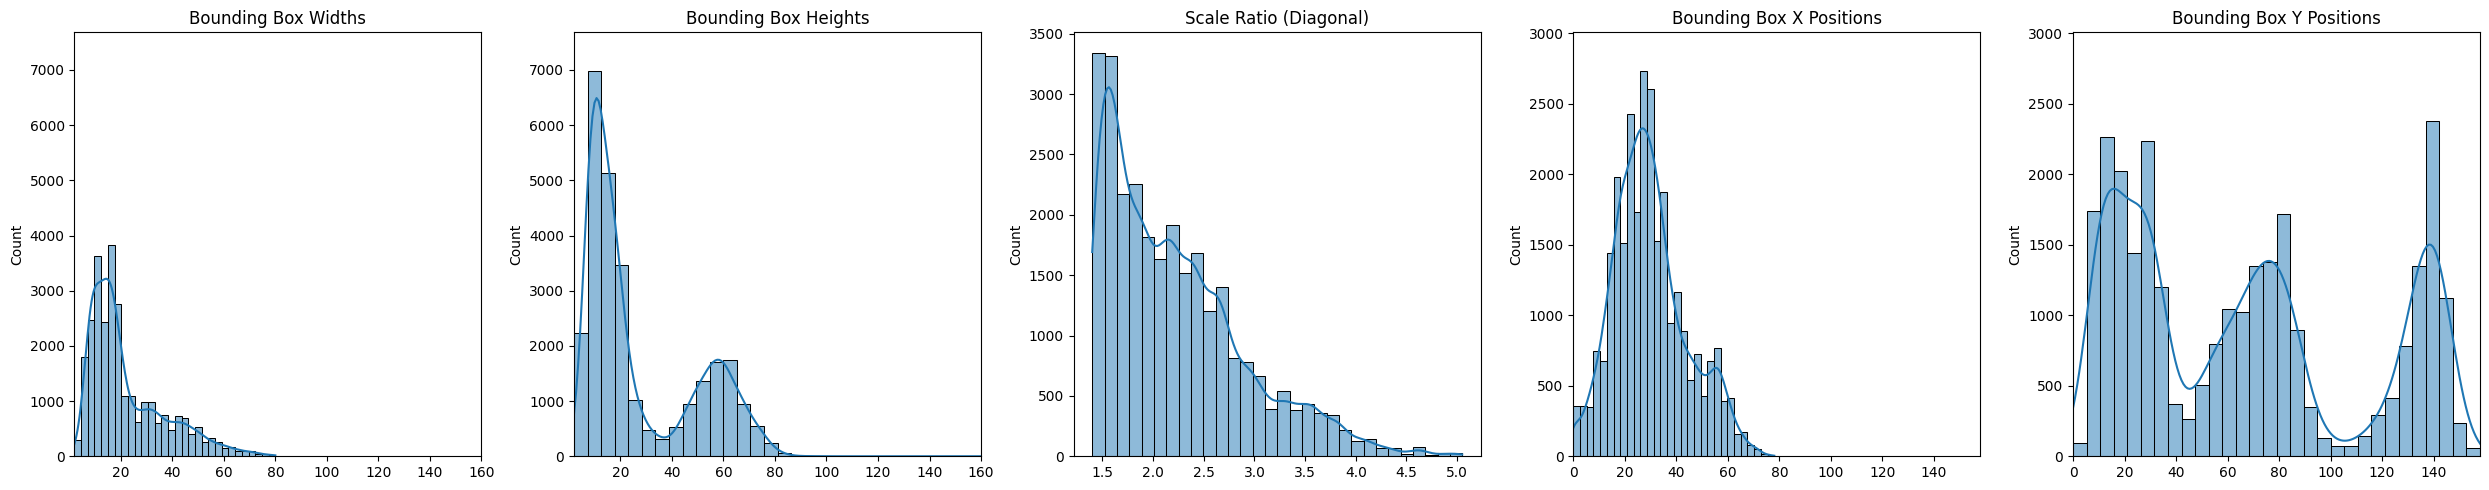

In [110]:
def analyze_part_distribution(bounding_boxes):
    fig, axes = plt.subplots(1, 2, figsize=(25, 7))

    # Plot histogram
    num_parts = [len(bbox) for bbox in bounding_boxes]  # Number of parts per image
    sns.histplot(num_parts, bins=range(1, max(num_parts) + 2), ax=axes[0])

    # Plot bargraph
    categories = list()
    frequencies = list()

    for key, value in cls_freq.items():
        categories.append(pixel_labels[key])
        frequencies.append(value)

    # Plot using seaborn
    sns.barplot(x=categories, y=frequencies, color='blue', ax=axes[1])

    axes[0].set_xlabel("Number of Parts per Image")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Distribution of Parts in Dataset")

    # Labels and title
    axes[1].set_xlabel("Categories")
    axes[1].set_ylabel("Number of Bboxes")
    axes[1].set_title("No. of Bboxes for each category")

    plt.tight_layout()
    plt.show()

def analyze_bbox_statistics(original_images, mask_images, bounding_boxes):
    widths, heights, x_positions, y_positions, scale_ratios = [], [], [], [], []

    for i in range(len(original_images)):
        img_h, img_w = original_images[i].shape[:2]
        mask_h, mask_w = mask_images[i].shape[:2]

        # Compute diagonal lengths
        img_diag = np.sqrt(img_w**2 + img_h**2)
        mask_diag = np.sqrt(mask_w**2 + mask_h**2)

        for (x, y, w, h) in bounding_boxes[i]:
            widths.append(w)
            heights.append(h)
            x_positions.append(x)
            y_positions.append(y)

            # Compute scale ratio using diagonal length
            scale_ratios.append(img_diag / mask_diag if mask_diag != 0 else 0)

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 1 row, 5 columns

    # Determine x and y limits for consistency
    x_limits = [min(widths + heights), max(widths + heights)]
    pos_limits = [min(x_positions + y_positions), max(x_positions + y_positions)]

    y_max_width_height = max(
        max(np.histogram(widths, bins=30)[0]),
        max(np.histogram(heights, bins=30)[0])
    ) * 1.1

    y_max_positions = max(
        max(np.histogram(x_positions, bins=30)[0]),
        max(np.histogram(y_positions, bins=30)[0])
    ) * 1.1

    # Bounding Box Widths
    sns.histplot(widths, bins=30, kde=True, ax=axes[0])
    axes[0].set_title("Bounding Box Widths")
    axes[0].set_xlim(x_limits)
    axes[0].set_ylim(0, y_max_width_height)

    # Bounding Box Heights
    sns.histplot(heights, bins=30, kde=True, ax=axes[1])
    axes[1].set_title("Bounding Box Heights")
    axes[1].set_xlim(x_limits)
    axes[1].set_ylim(0, y_max_width_height)

    # Scale Ratio (Image Diagonal / Mask Diagonal)
    sns.histplot(scale_ratios, bins=30, kde=True, ax=axes[2])
    axes[2].set_title("Scale Ratio (Diagonal)")

    # Bounding Box X Positions
    sns.histplot(x_positions, bins=30, kde=True, ax=axes[3])
    axes[3].set_title("Bounding Box X Positions")
    axes[3].set_xlim(pos_limits)
    axes[3].set_ylim(0, y_max_positions)

    # Bounding Box Y Positions
    sns.histplot(y_positions, bins=30, kde=True, ax=axes[4])
    axes[4].set_title("Bounding Box Y Positions")
    axes[4].set_xlim(pos_limits)
    axes[4].set_ylim(0, y_max_positions)

    plt.tight_layout()
    plt.show()

analyze_part_distribution(bounding_boxes)
print()
analyze_bbox_statistics(images, masks, bounding_boxes)

### Challenges and Interesting patterns

> After looking at the earlier distributions I realised that in the dataset there are only 100 bounding boxes for the class 'leg' so while extracting bounding boxes from segment masks I converted all the 'leg' pixels to 'lower' itself and trained the model on 7 classes instead of 8.

> We can notice that the scale ratio of Image/Mask image is >= 1.5, that forced me to scale the bounding boxes coordinates generated from the mask image with the same scale factor to fit it onto the original Image.

> From the histogram of BB y-coordinates we can see 3 distint peaks as expected as the human body can also be divided into 3 segements - the first one represents the head + torso portion as the y_min of both the body parts will lie near each other (as head is very small compared to torso) - hence a broader first peak - while the legs/lower BB start where the torso ends indicating the second peak and the third peak is for shoes/footwear which is at the most bottom and constitutes the third peak in the histogram.

> BB x-coordinates follow an overall gaussian curve starting near the left edge with a padding of around 30 pixels on average which denotes that the data has been clearly crafted to ensure uniformity in the position of the data sample in the image.

> The 2 peaks in the histogram for BB heights denote that mostly 2 size categories of Bboxes can be seen, the smaller ones are for footwear + face + hair, the middle ones belong to hands mostly and the largest peak corresponds to torso and lower (same height in the histogram as well)

## Data Transform & Augmentation

In [66]:
MEAN = (0.485, 0.456, 0.406)
STD_DEV = (0.229, 0.224, 0.225)

# Define data augmentation
def get_transform(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=MEAN, std=STD_DEV),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.1)) # Added min_visibility
    else:
        return A.Compose([
            A.Normalize(mean=MEAN, std=STD_DEV),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.1)) # Added min_visibility

## Dataset Class

In [67]:
class PartsDataset(Dataset):
    def __init__(self, images, bboxes, labels, transforms=None):
        self.images = images
        self.bboxes = bboxes
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        boxes = self.bboxes[idx]
        labels = self.labels[idx]

        # Convert to Float Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Prepare target dictionary
        target = {"boxes": boxes, "labels": labels}

        # Apply transforms
        if self.transforms:
            transformed = self.transforms(image=img, bboxes=boxes, labels=labels)  # Ensure list format
            img = transformed['image']
            target["boxes"] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target["labels"] = torch.as_tensor(transformed['labels'], dtype=torch.int64)  # Ensure transformed labels are tensors

        return img, target

## Function to load pretrained Faster RCNN with FPN Network (ResNet50 Backbone)

In [71]:
def get_model(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Modify the classifier to match the number of classes (num_classes includes background)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Justification for architecture selection

I used specifically the Faster RCNN architecture for it's higher accuracy and ability to tackle smaller objects as well - as in our dataset we had many small objects in the images like shoes, hair, face etc. Also the dataset provided is comparitively small so did not use DETR family as they are transformer based architecture and requires larger amounts of data to train/fine-tune. Similarly for YOLO family I did not select them because even though they are faster than faster-RCNN but their accuracy and ability to precisely capture small objects is not very great. And for the RetinaNet family to be discarded the reason was lower accuracy as compared to FasterRCNN. So alternate to the model chosen I would prefer to experiment with RetinaNet architecture followed by YOLO.

### Modifications in the Base Architecture
Changed the final Bbox predicting block to map to the given number of classes in the dataset, rest everything I kept the same.

## Dataloaders & Formatting Data

In [72]:
# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Convert (xmin, ymin, w, h) to (xmin, ymin, xmax, ymax) [Pascal Format]
# Make sure to keep it in list[list[list]] format and not a tuple -> Needed when passed in to convert to tensor
train_bboxes_pascal = []
for per_img_bboxes in train_scaled_bboxes:
    this_img_pascal_bboxes = []
    for bbox in per_img_bboxes:
        x, y, w, h = bbox
        this_img_pascal_bboxes.append([x, y, x + w, y + h])
    train_bboxes_pascal.append(this_img_pascal_bboxes)

val_bboxes_pascal = []
for per_img_bboxes in val_scaled_bboxes:
    this_img_pascal_bboxes = []
    for bbox in per_img_bboxes:
        x, y, w, h = bbox
        this_img_pascal_bboxes.append([x, y, x + w, y + h])
    val_bboxes_pascal.append(this_img_pascal_bboxes)

# Create dataset & data loaders
train_dataset = PartsDataset(train_images, train_bboxes_pascal, train_labels, transforms=get_transform(train=True))
val_dataset = PartsDataset(val_images, val_bboxes_pascal, val_labels, transforms=get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

## Training Loop

In [74]:
model_save_path = "/kaggle/working/model_weights_2.pth"

if not os.path.exists(model_save_path):
    # Load model
    # num_classes = 8  # face, hair, shirt, hand, lower, leg, shoes, background
    num_classes = 7 # After merging leg with lower
    model = get_model(num_classes).to(device)

    # Define optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=1e-4)

    # Define LR scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = 20
    gpu_mem = []
    cpu_usage = []
    ram_usage = []
    loss_arr = []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            # Backward
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            gpu_mem.append(torch.cuda.memory_allocated() / 1e9)  # Convert to GB
            cpu_usage.append(psutil.cpu_percent())
            ram_usage.append(psutil.virtual_memory().percent)

        lr_scheduler.step()
        loss_arr.append(total_loss/len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")

    end_time = time.time()
    print(f"Training time = {round(end_time - start_time, 3)}s")

    torch.save(model, model_save_path)
    print(f"Model saved at:{model_save_path}")
else:
    print("Model has already been trained so loading pretrained model")
    model = torch.load(model_save_path)
    model.to(device)

Epoch 1/20, Loss: 1.021169820969755
Epoch 2/20, Loss: 0.9212469210979914
Epoch 3/20, Loss: 0.8819792674797954
Epoch 4/20, Loss: 0.8627570388895093
Epoch 5/20, Loss: 0.8414976053466701
Epoch 6/20, Loss: 0.7729275000065264
Epoch 7/20, Loss: 0.7533480914478953
Epoch 8/20, Loss: 0.7416710523192329
Epoch 9/20, Loss: 0.7344586805939072
Epoch 10/20, Loss: 0.7241908461231776
Epoch 11/20, Loss: 0.7080673724412918
Epoch 12/20, Loss: 0.7056457748392013
Epoch 13/20, Loss: 0.7056341500520104
Epoch 14/20, Loss: 0.7058355637797804
Epoch 15/20, Loss: 0.7017181834036653
Epoch 16/20, Loss: 0.7009446433924064
Epoch 17/20, Loss: 0.7000506139463849
Epoch 18/20, Loss: 0.6985528457420643
Epoch 19/20, Loss: 0.700507792747683
Epoch 20/20, Loss: 0.6985959779809822
Training time = 17719.094s
Model saved at:/kaggle/working/model_weights_2.pth


## Plotting resource utilisation graphs & Loss Curve

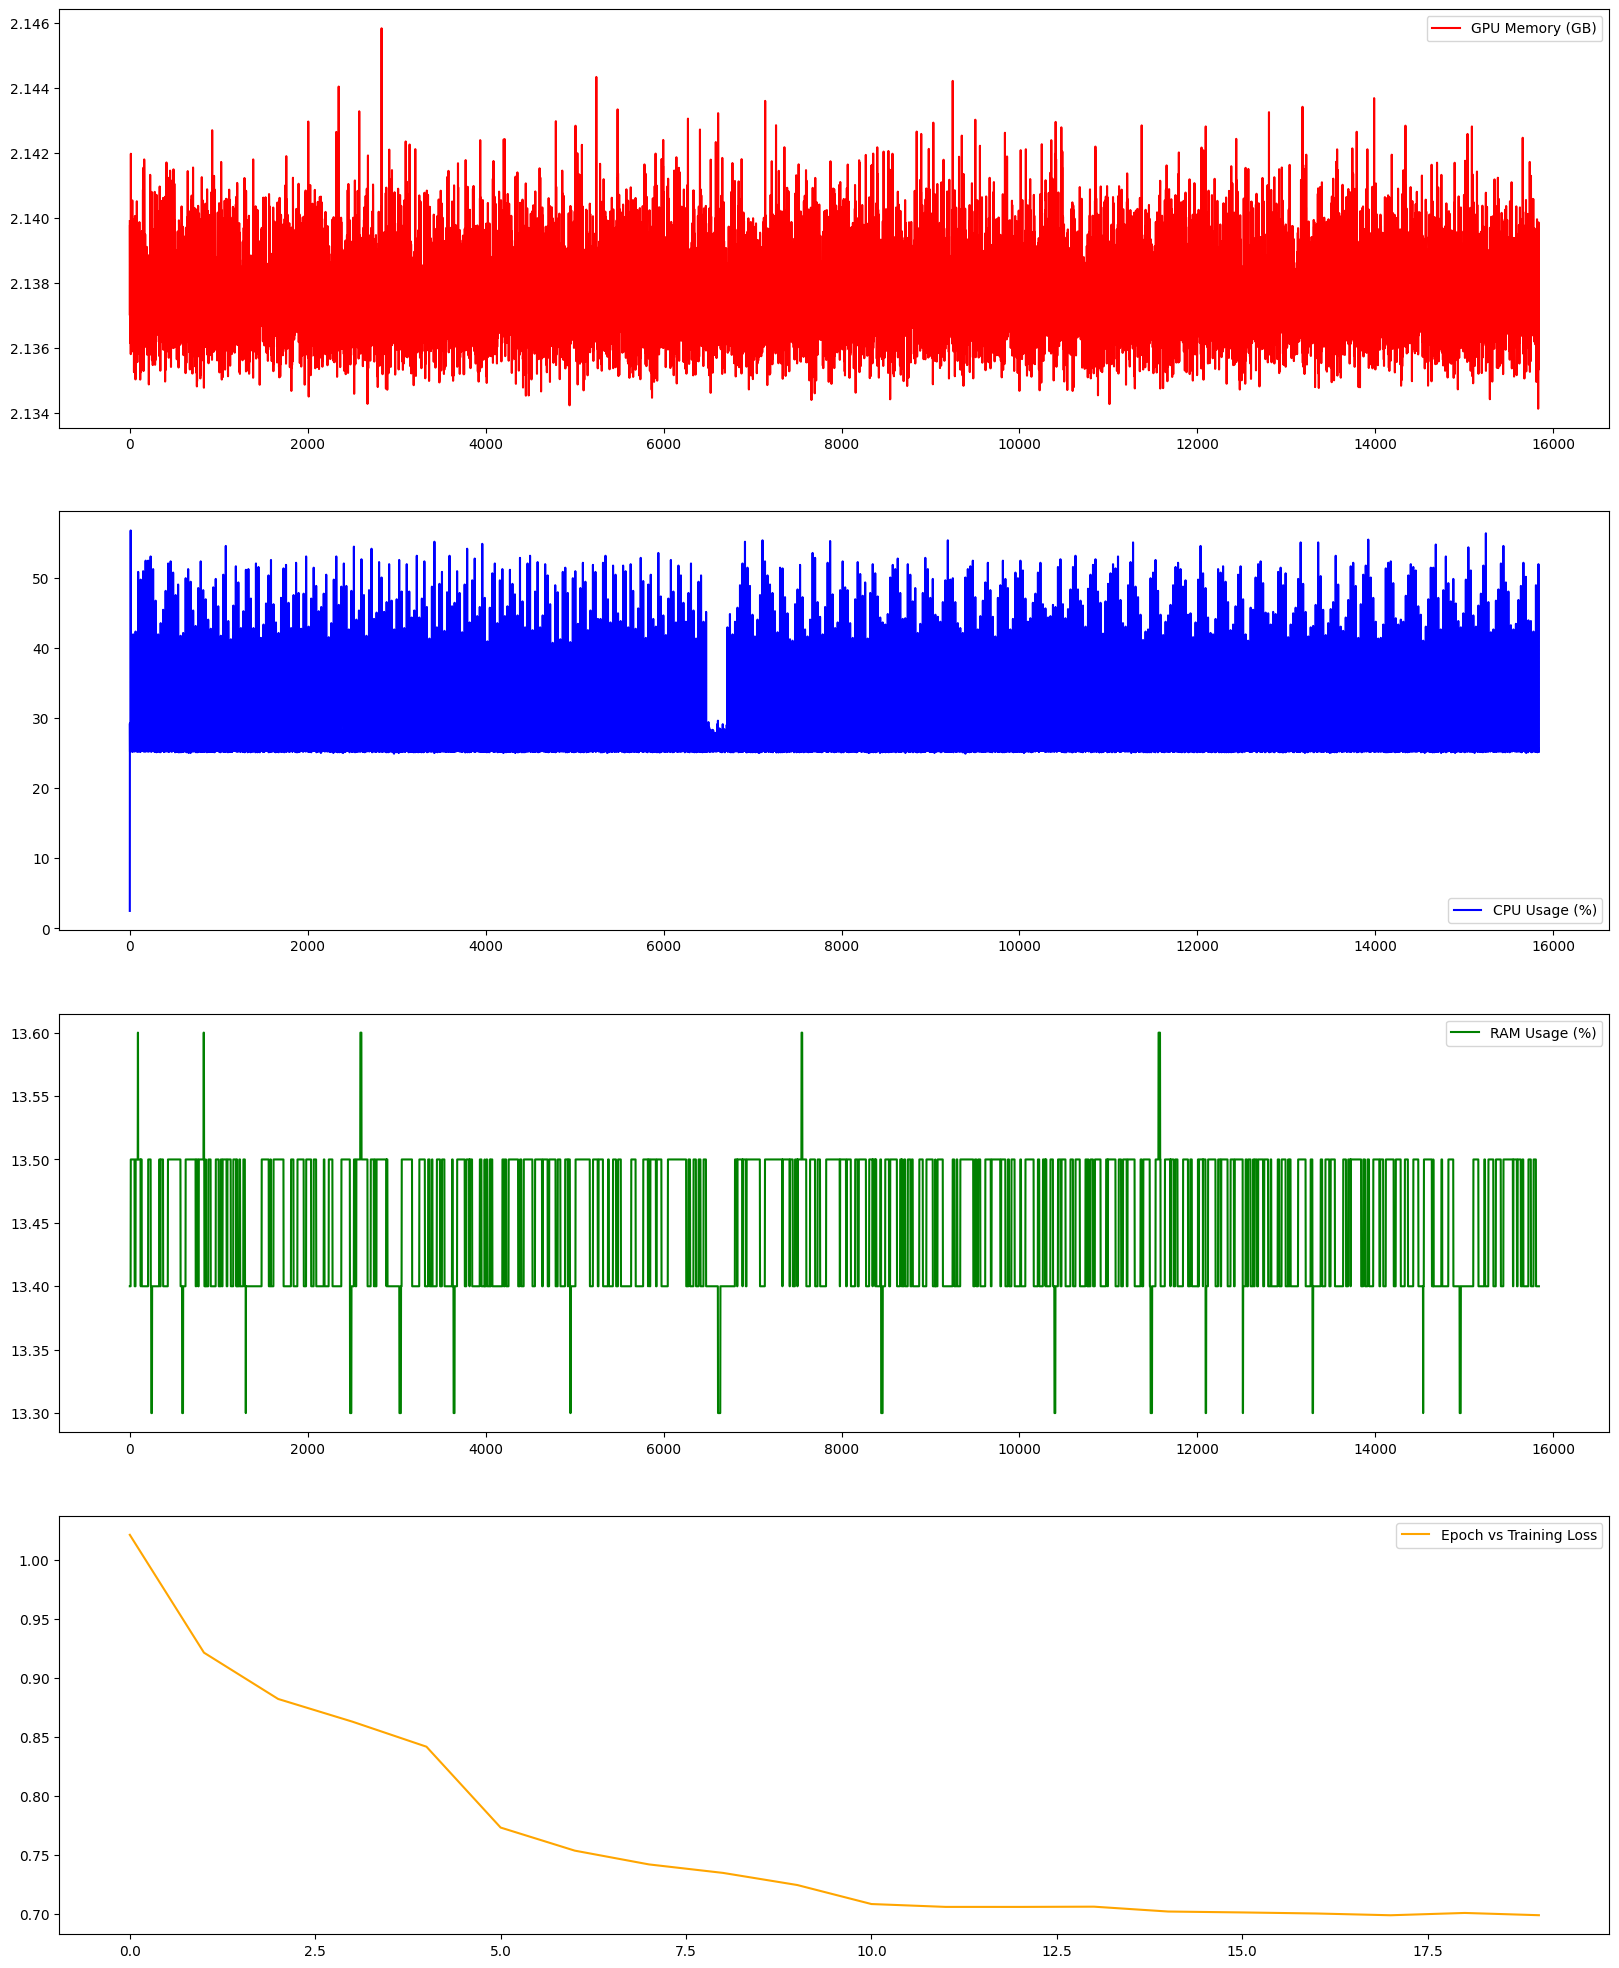

In [79]:
try:
    plt.figure(figsize=(20, 25))
    plt.subplot(4, 1, 1)
    plt.plot(gpu_mem, label="GPU Memory (GB)", color="red")
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(cpu_usage, label="CPU Usage (%)", color="blue")
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(ram_usage, label="RAM Usage (%)", color="green")
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(loss_arr, label="Epoch vs Training Loss", color="orange")
    plt.legend()

    plt.savefig("/kaggle/working/resource_utilisation_graphs.png", dpi=300)
    plt.show()
except:
    print("Loaded the pretrained model so nothing to plot.")

## Predicting & Visualising some Bbox predictions

Sample visualisations:


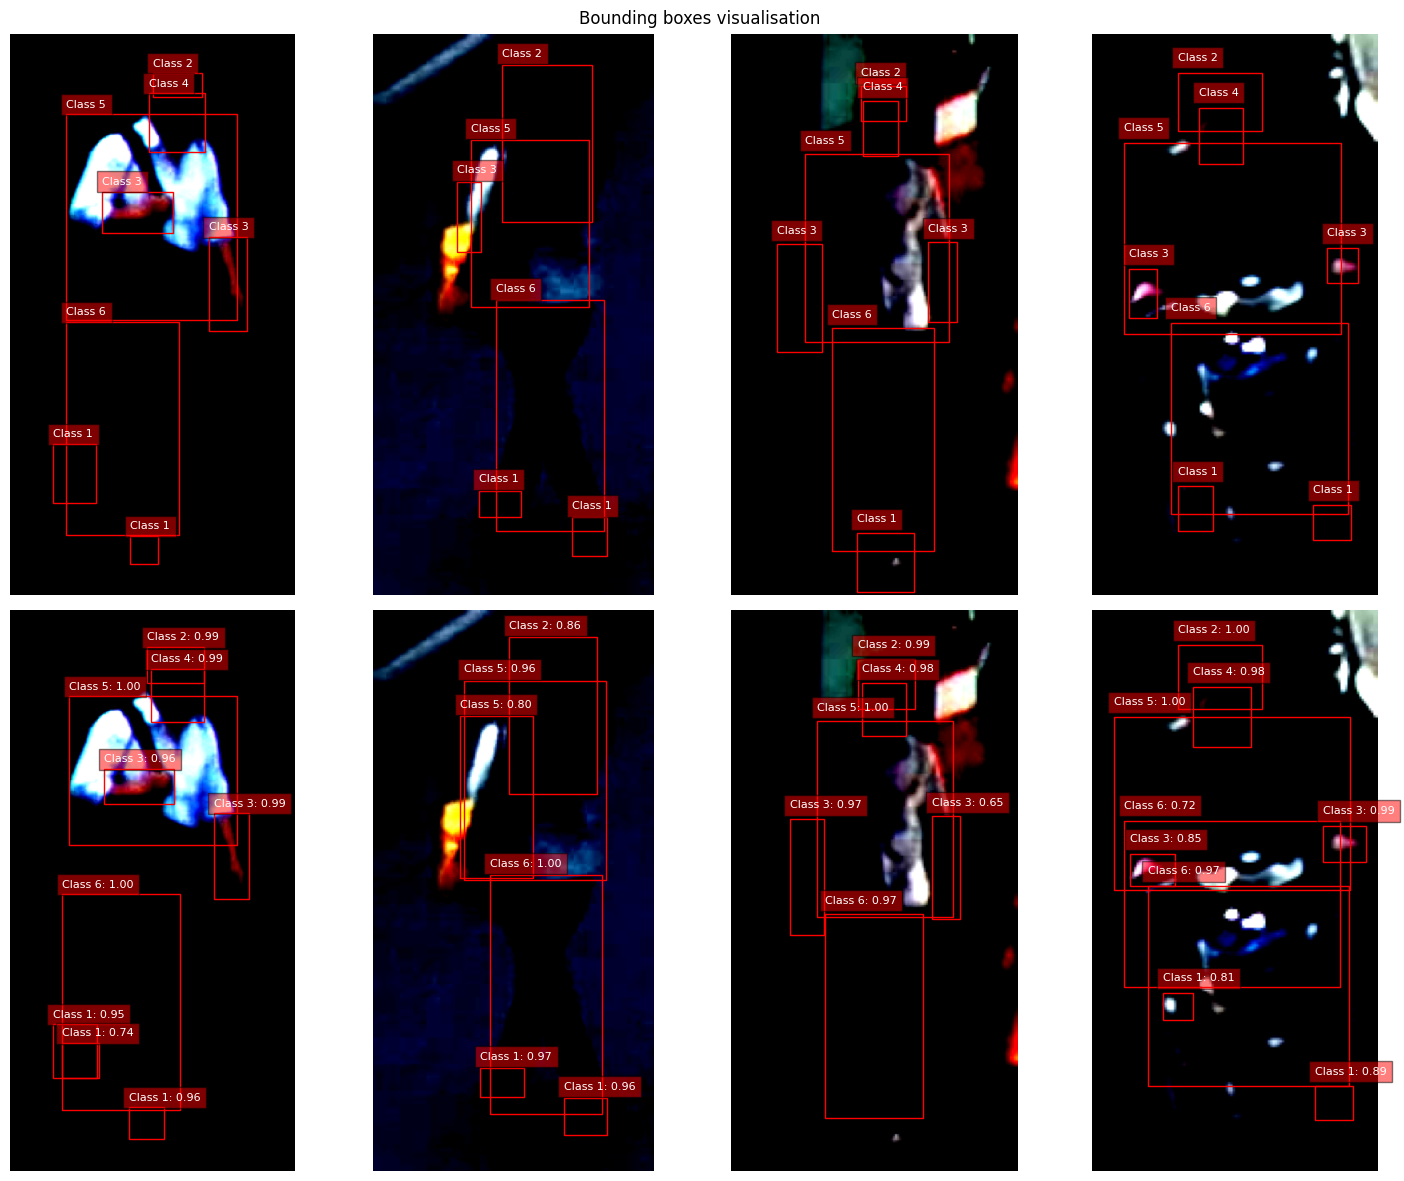

In [91]:
confidence_th = 0.5

model.eval()

predictions = []
ground_truths = []
images_arr = []

with torch.no_grad():
    batch_idx = -1
    for images, targets in val_loader:
        batch_idx += 1
        images_arr.extend(images)
        ground_truths.extend(targets)

        images = [img.to(device) for img in images]
        outputs = model(images)  # Get model predictions

        for output in outputs:
            predictions.append(
                {
                    'boxes': output['boxes'].cpu(),
                    'labels': output['labels'].cpu(),
                    'scores': output['scores'].cpu()
                }
            )

        if batch_idx == 1:
            # print("Sample output:")
            # print(outputs)
            print("Sample visualisations:")
            
            fig, ax = plt.subplots(2, len(images), figsize=(15, 12))

            for i in range(len(images)):
                img = images[i].permute(1, 2, 0).cpu().numpy()
                ax[0][i].imshow(img)
                ax[0][i].axis('off')

                if len(targets[i]['boxes']) > 0:
                    for box, label in zip(targets[i]['boxes'], targets[i]['labels']):
                        x_min, y_min, x_max, y_max = box.cpu().numpy()
                        width = x_max - x_min
                        height = y_max - y_min
                        linewidth = 1

                        rect = patches.Rectangle(
                            (x_min, y_min), width, height, linewidth=linewidth,
                            edgecolor='red', facecolor='none'
                        )
                        ax[0][i].add_patch(rect)

                        # Display class label
                        ax[0][i].text(
                            x_min, y_min - 5, f'Class {label}',
                            bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white'
                        )
            
            for i in range(len(images)):
                img = images[i].permute(1, 2, 0).cpu().numpy()
                ax[1][i].imshow(img)
                ax[1][i].axis('off')

                if len(outputs[i]['boxes']) > 0:
                    for box, label, score in zip(outputs[i]['boxes'], outputs[i]['labels'], outputs[i]['scores']):
                        if score > confidence_th:  # Confidence threshold
                            x_min, y_min, x_max, y_max = box.cpu().numpy()
                            width = x_max - x_min
                            height = y_max - y_min
                            linewidth = 1  # Line width proportional to score

                            rect = patches.Rectangle(
                                (x_min, y_min), width, height, linewidth=linewidth,
                                edgecolor='red', facecolor='none'
                            )
                            ax[1][i].add_patch(rect)

                            # Display class label
                            ax[1][i].text(
                                x_min, y_min - 5, f'Class {label}: {score:.2f}',
                                bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white'
                            )
                            
            plt.suptitle("Bounding boxes visualisation")
            plt.tight_layout()
            plt.show()

## Computing mAP and plotting PR-Curve

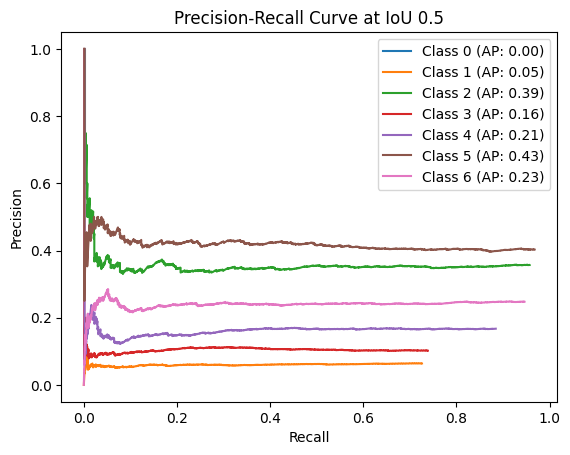

mAP at IoU 0.5: 0.210


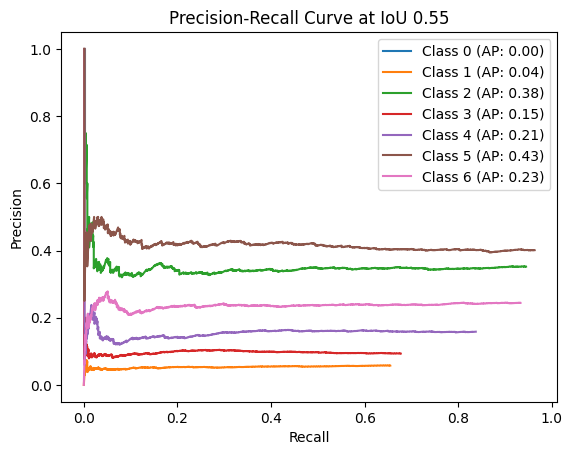

mAP at IoU 0.55: 0.205


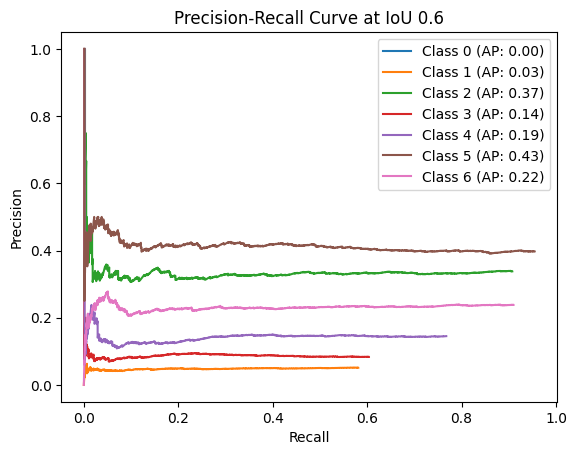

mAP at IoU 0.6: 0.196


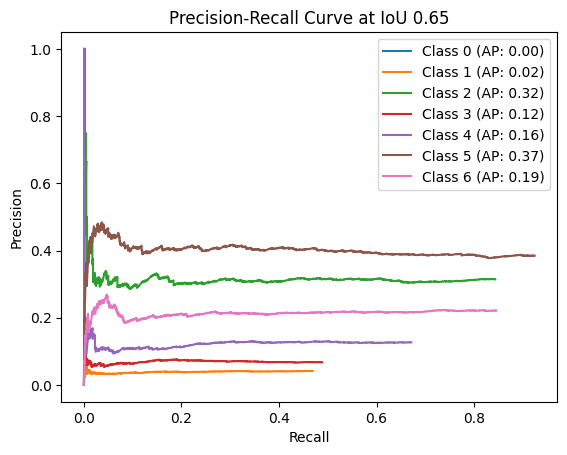

mAP at IoU 0.65: 0.169


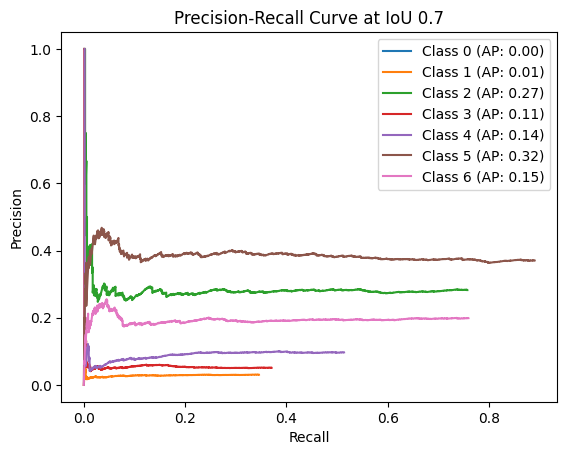

mAP at IoU 0.7: 0.143


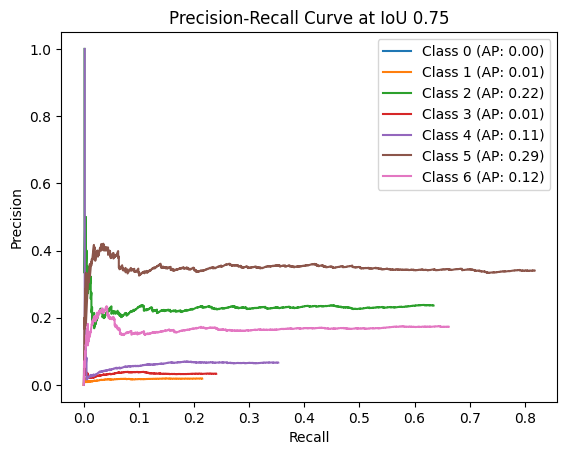

mAP at IoU 0.75: 0.109


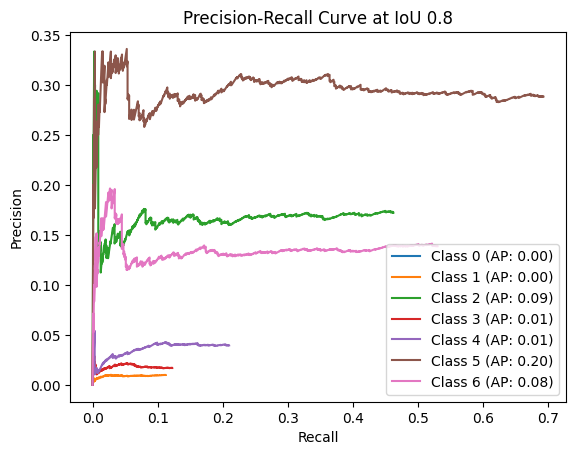

mAP at IoU 0.8: 0.056


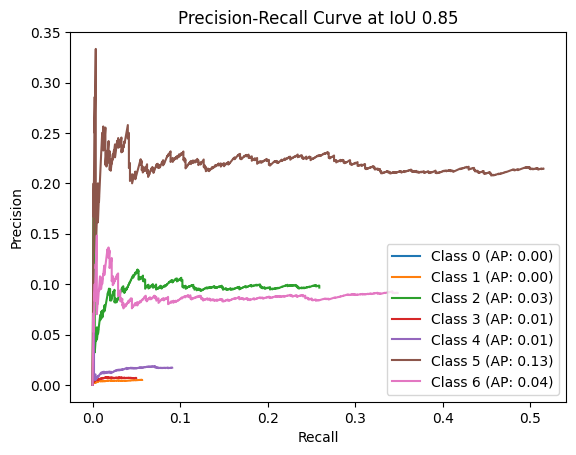

mAP at IoU 0.85: 0.031


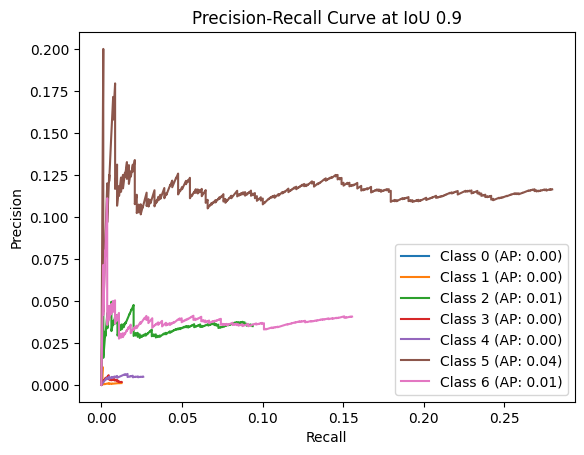

mAP at IoU 0.9: 0.009


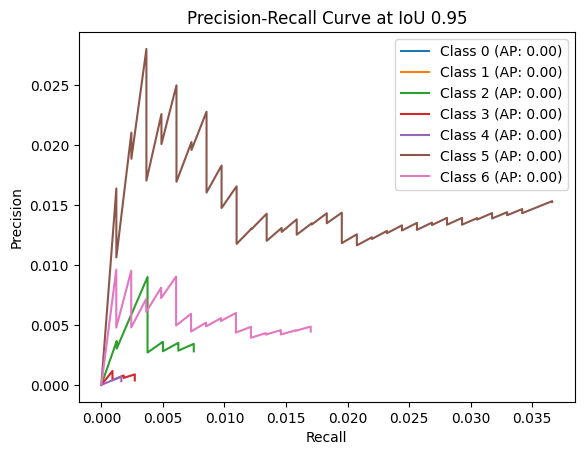

mAP at IoU 0.95: 0.001


In [81]:
def calculate_iou(box1, box2):
    # Get coordinates of the intersection box
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])

    # Compute the area of intersection
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    intersection_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute IoU
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area if union_area != 0 else 0

    return iou

def compute_precision_recall(predictions, ground_truths, class_id, iou_threshold):
    all_detections = []
    all_gt_boxes = 0

    for img_preds, img_gts in zip(predictions, ground_truths):
        pred_boxes = np.array(img_preds['boxes'])
        pred_labels = np.array(img_preds['labels'])
        pred_scores = np.array(img_preds['scores'])

        gt_boxes = np.array(img_gts['boxes'])
        gt_labels = np.array(img_gts['labels'])

        # Filter by class_id
        pred_mask = pred_labels == class_id
        gt_mask = gt_labels == class_id

        pred_boxes = pred_boxes[pred_mask]
        pred_scores = pred_scores[pred_mask]

        gt_boxes = gt_boxes[gt_mask]
        all_gt_boxes += len(gt_boxes)

        # Sort predictions by confidence score
        sorted_indices = np.argsort(-pred_scores)
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]

        tp, fp = [], []
        used_gt = set()

        for pred_box in pred_boxes:
            best_iou, best_gt_idx = 0, -1

            for idx, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou, best_gt_idx = iou, idx

            if best_iou >= iou_threshold and best_gt_idx not in used_gt:
                tp.append(1)
                fp.append(0)
                used_gt.add(best_gt_idx)
            else:
                tp.append(0)
                fp.append(1)

        all_detections.extend(zip(tp, fp))

    # Compute cumulative TP and FP
    tp_cumsum = np.cumsum([tp for tp, _ in all_detections])
    fp_cumsum = np.cumsum([fp for _, fp in all_detections])
    recall = tp_cumsum / max(all_gt_boxes, 1)
    precision = tp_cumsum / np.maximum(tp_cumsum + fp_cumsum, 1e-6)

    return precision, recall

def compute_average_precision(precision, recall):
    recall_levels = np.linspace(0, 1, 11)
    max_precision = [max(precision[recall >= r]) if np.any(recall >= r) else 0 for r in recall_levels]
    return np.mean(max_precision)

def compute_map(predictions, ground_truths, class_list, iou_thresholds):
    results = {}
    for iou_thresh in iou_thresholds:
        ap_per_class = {}

        for class_id in class_list:
            precision, recall = compute_precision_recall(predictions, ground_truths, class_id, iou_thresh)
            ap = compute_average_precision(precision, recall)
            ap_per_class[class_id] = ap

            # Plot PR curve
            plt.plot(recall, precision, label=f"Class {class_id} (AP: {ap:.2f})")

        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve at IoU {iou_thresh}")
        plt.legend()
        plt.savefig(f"/kaggle/working/PR_Curve_{iou_thresh}.png", dpi=300)
        plt.show()

        # Compute mean AP across all classes
        results[iou_thresh] = np.mean(list(ap_per_class.values()))
        print(f"mAP at IoU {iou_thresh}: {results[iou_thresh]:.3f}")

    return results

class_list = list(range(7))

# Compute mAP and plot PR curves (Using COCO mAP)
map_results = compute_map(predictions, ground_truths, class_list, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

### Qualitative Analysid of detection results

The results that came out of my model are not impressive. I believe this happened due to the normalisation and brightness adjustment augmentations, in contrast I propose to use just normal min-max normlisation with color jitter for better results. If time permits I will experiment in that setting (as you can see it almost took 6 hours for the model to train).

## Analysis of performance across body parts:

| IoU threshold | Class $0_{AP}$ | Class $1_{AP}$ | Class $2_{AP}$ | Class $3_{AP}$ | Class $4_{AP}$ | Class $5_{AP}$ | Class $6_{AP}$ | $m_{AP}$  | Adjusted $m_{AP}$ |
|--------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|--------------------------------|----------------------------------|
| 0.50        | 0.00          | 0.05          | 0.39          | 0.16          | 0.21          | 0.43          | 0.23          | <span style="color:yellow">0.210</span> | <span style="color:green">0.245</span> |
| 0.55        | 0.00          | 0.04          | 0.38          | 0.15          | 0.21          | 0.43          | 0.23          | <span style="color:yellow">0.205</span> | <span style="color:green">0.240</span> |
| 0.60        | 0.00          | 0.03          | 0.37          | 0.14          | 0.19          | 0.43          | 0.22          | <span style="color:yellow">0.196</span> | <span style="color:green">0.230</span> |
| 0.65        | 0.00          | 0.02          | 0.32          | 0.12          | 0.16          | 0.37          | 0.19          | <span style="color:yellow">0.169</span> | <span style="color:green">0.197</span> |
| 0.70        | 0.00          | 0.01          | 0.27          | 0.11          | 0.14          | 0.32          | 0.15          | <span style="color:yellow">0.143</span> | <span style="color:green">0.167</span> |
| 0.75        | 0.00          | 0.01          | 0.22          | 0.01          | 0.11          | 0.29          | 0.12          | <span style="color:yellow">0.109</span> | <span style="color:green">0.127</span> |
| 0.80        | 0.00          | 0.00          | 0.09          | 0.01          | 0.01          | 0.20          | 0.08          | <span style="color:yellow">0.056</span> | <span style="color:green">0.065</span> |
| 0.85        | 0.00          | 0.00          | 0.03          | 0.01          | 0.01          | 0.13          | 0.04          | <span style="color:yellow">0.031</span> | <span style="color:green">0.037</span> |
| 0.90        | 0.00          | 0.00          | 0.01          | 0.00          | 0.00          | 0.04          | 0.01          | <span style="color:yellow">0.009</span> | <span style="color:green">0.010</span> |
| 0.95        | 0.00          | 0.00          | 0.00          | 0.00          | 0.00          | 0.00          | 0.00          | <span style="color:yellow">0.001</span> | <span style="color:green">0.000</span> |


As we can see from the table that the highest AP is mostly in the order of Class 5 (torso), 2 (hair), 6 (lower), 4 (face), 3 (hand), 1 (footwear), 0 (background)

> This makes sense that backgound has 0 AP as we did not have any Bboxes for that so no training and no prediction, also I propose that the class performance very much depends on the number of samples, and inversely proportional to the size of the object in the images for example even though footwear had a lot of training samples even then it performed poorly was because each image had multiple instances of the same object as well as the bboxes are quiet small as compared to other moderate number of samples of torso, lower and face and decent sized Bbox and a single sample present per image.

## Analysis of Failure and Success Cases

### Success Cases:
1. **Higher AP for larger and prominent parts:**  
   - Torso (Class 5), Hair (Class 2), and Lower Body (Class 6) had the best AP scores.  
   - These parts usually occupy a larger region in the image and have fewer occlusions.  
   - The model was able to detect them with better precision and recall.

2. **Decent performance for moderately sized parts:**  
   - Face (Class 4) and Hand (Class 3) showed moderate AP scores.  
   - These parts had reasonable sizes and training samples, contributing to their detection success.  

### Failure Cases:
1. **Poor performance for small objects (Footwear - Class 1):**  
   - Even with many training samples, footwear had lower AP.  
   - This was likely due to:
     - Multiple small instances per image, making it harder to detect.
     - High overlap leading to incorrect bounding box predictions.

2. **Zero AP for Background (Class 0):**  
   - Since no bounding boxes were provided for the background, the model never learned to classify it.  
   - This resulted in a 0 AP score and possibly affected training stability.

3. **Impact of Occlusion and Viewpoint Variation:**  
   - Overlapping body parts (e.g., hands over the torso, legs occluded by clothing) likely affected detection.  
   - Certain viewpoints might make some parts less visible (e.g., side views hiding one hand or foot).

---

## Potential Improvements

### 1. Architectural Modifications for Better Parts Detection:
- **Switch to Cascade R-CNN:**  
  - Uses multiple detection stages with increasing IoU thresholds, improving precision.
- **Replace ResNet-50 with Swin Transformer or HRNet:**  
  - These architectures retain more spatial details, which is crucial for small and overlapping parts.

### 2. Alternative Approaches to Handle Challenging Cases:
- **Use Soft-NMS (Non-Maximum Suppression):**  
  - Reduces suppression for overlapping objects, helping detect multiple small instances like footwear.
- **Train with Balanced Sampling:**  
  - Ensures all classes get fair representation, preventing bias towards larger parts.

### 3. Incorporating Part Relationships and Hierarchical Structure:
- **Graph Neural Networks (GNNs) for Part Relationships:**  
  - Human body parts follow a structured relationship (e.g., hand → arm → torso).  
  - A GNN-based model can enforce these constraints during training.
- **Pose-Guided Part Detection:**  
  - Using keypoint detection (e.g., from HRNet) to refine part locations.
- **Hierarchical Loss Function:**  
  - Penalize incorrect predictions more when misclassifying between related parts (e.g., foot vs. footwear).  

---

### **Note:**
<span style="color:red"> Note that by mistake here I trained the model with 6 classes (including background class) but did not have any training sample for that in the training data so this affected the model's performance, in case the time permits I will modify the code and train only for the given 5 classes - excluding background</span>